# Prerequisites

In [2]:
%matplotlib inline
%run fcast.py

# customize matplotlib plots
mpl.style.use('seaborn-darkgrid')
plt.rc('font', family='TH Sarabun New')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes',  labelsize=16)
plt.rc('figure', figsize=(6.5,4), dpi=300)

Using TensorFlow backend.


# Workflow

1. **Prepare data**
    1. **Transform** data i.e. taking log, scaling, and differencing.
> If data is transformed, prediction must be converted by **inversing transformation** operations.
    2. **Split** data into three sets e.g. train, validation and test set. For example, 60:20:20 proportion.
    3. For deep learning, we need to reshape data **to [Keras](https://keras.io)** format.
        1. Number of periods to used as model's input.
        2. Number of periods to forecast as model's output.


2. **Grid search** for the best hyper-parameters (configs).
    1. For each hyper-parameter, **fit the model** using **train set**.  
    2. **Walk forward validation** over the **validation set**.  
    3. **Measure** the model's performance via some metrics. In this case, we use RMSE.  
    4. For deep learning techniques, **repeat** step A-C n times because deep learning is stochastic.
    5. **Select** the best config based on RMSE.
    
    
3. **Forecast**.
    1. **Combine** train and validation set called it **train2 set**.
    2. **Refit model** using **train2 set** and the config from step 1.
    3. **Walk forward validation** over the **test set**.
    4. **Measure** the model's performance using RMSE.
    5. For deep learning techniques, **repeat** step B-D.
    6. **Return** model's performance, predicted.
    
    
4. **Evaluate** models including
    - Naive or Persistent model (NAIVE) 
    - Exponential Smoothing (ES) 
    - Seasonal Autoregressive Integrated Moving Average (SARIMA)
    - Multilayer Perceptron (MLP) 
    - Long Short-Term Memory (LSTM)

# Structure of defined functions
1. `data_` means data preparation steps
    1. `data_split`
    2. `data_transform`
    3. `data_reshape`
    
    
2. `model_` means model steps
    1. `model_config`
    2. `model_fit`
    3. `model_predict`


3. `eval_`


4. `plot_`

# Prepare data

## Import price data

โหลดข้อมูลราคาข้าวเปลือกที่เกษตรกรขายได้ 3 ชนิดข้าว ได้แก่ ข้าวหอมมะลิ (`hml`) ข้าวเจ้าขาว (`wht`) และข้าวเหนียว (`glu`)  
นอกจากนี้ ยังเพิ่มข้อมูล metadata ประกอบด้วยตัวย่อ(abb) ชื่อย่อ (shortname) และ ชื่อเต็ม(fullname)

In [3]:
hml = read_price('hml')
hml.meta = SimpleNamespace()
hml.meta.abb = 'hml'
hml.meta.shortname = 'ข้าวหอมมะลิ'
hml.meta.fullname = 'ราคาข้าวเปลือกหอมมะลิ ที่เกษตรกรขายได้ ณ ไร่นา'

wht = read_price('wht')
wht.meta = SimpleNamespace()
wht.meta.abb = 'wht'
wht.meta.shortname = 'ข้าวเจ้าขาว'
wht.meta.fullname = 'ราคาข้าวเปลือกเจ้าขาว ที่เกษตรกรขายได้ ณ ไร่นา'

glu = read_price('glu')
glu.meta = SimpleNamespace()
glu.meta.abb = 'glu'
glu.meta.shortname = 'ข้าวเหนียว'
glu.meta.fullname = 'ราคาข้าวเปลือกเหนียวเมล็ดยาว ที่เกษตรกรขายได้ ณ ไร่นา'

prices = [hml, wht, glu]

## Policy data
เพิ่มข้อมูล dummy ปีที่มีนโยบายจำนำข้าวทุกเมล็ดของรัฐบาลยิ่งลักษณ์ ระหว่าง Oct 2010 - Feb 2014

In [4]:
exo = pd.DataFrame(index = wht.index)
exo['pledge_scheme'] = 0
exo.loc['2011-10':'2014-2'] = 1

## Data Transformation

In [5]:
for price in prices:
    price.scaled, price.scaler = data_transform(price, method=None)
    price.train, price.validate, price.train2, price.test = data_split(price.scaled)

# Exponential Smoothing

In [6]:
def ets_fit(data, config, n_periods=12):
    trend, damped, seasonal = config
    return ets(data, trend=trend, damped=damped,
               seasonal=seasonal,seasonal_periods=n_periods
              ).fit(use_boxcox='log')


def ets_forecast(model_fitted, data, n_forecast=4):
    scaler = getattr(data, "scaler")
    df = pd.DataFrame(model_fitted.forecast(n_forecast),
                      columns=["yhat_scaled"])
    df['yhat'] = scaler.inverse_transform(df)
    return df['yhat']


def ets_walk_forward(data, config, search_mode=False, n_forecast=4):
    train, test = select_traintest(data, search_mode)
    n_test = test.shape[0]
    n_yhat = n_test-n_forecast+1 # +1 for count adjustment
    yhat = np.empty((n_yhat, n_forecast))
    history = train
    for i in range(n_yhat):
        model_fitted = ets_fit(history, config)
        yhat[i] = ets_forecast(model_fitted, data, n_forecast)
        history = history.append(test.iloc[i])

    yhat = pd.DataFrame(yhat,
                        columns=[f'yhat{h}' for h in range(1, n_forecast+1)],
                        index=test.iloc[:n_yhat,].index)
    
    return yhat

In [7]:
trend = [None]
damped = [False]
seasonal = [None, 'add', 'mul']
conf1 = model_configs(trend, damped, seasonal)

trend = ['add', 'mul']
damped = [False, True]
seasonal = [None, 'add', 'mul']
conf2 = model_configs(trend, damped, seasonal)

ets_configs = [*conf1, *conf2]
ets_model = [ets_fit, ets_forecast, ets_walk_forward, ets_configs]
ets_configs

[(None, False, None),
 (None, False, 'add'),
 (None, False, 'mul'),
 ('add', False, None),
 ('add', False, 'add'),
 ('add', False, 'mul'),
 ('add', True, None),
 ('add', True, 'add'),
 ('add', True, 'mul'),
 ('mul', False, None),
 ('mul', False, 'add'),
 ('mul', False, 'mul'),
 ('mul', True, None),
 ('mul', True, 'add'),
 ('mul', True, 'mul')]

In [8]:
%%time
n_forecast=4
for price in prices:
    price.ets_grid_result, price.ets_config = grid_search(price, ets_model, n_forecast=n_forecast)
    price.ets_yhat = forecast(price, ets_model, price.ets_config, n_forecast=n_forecast)

{'None-False-None': {'rmse': 1313.6419, 'mae': 787.0213, 'mape': 0.061}}
{'None-False-add': {'rmse': 1356.1873, 'mae': 787.462, 'mape': 0.0596}}
{'None-False-mul': {'rmse': 1365.4211, 'mae': 799.4716, 'mape': 0.0606}}
{'add-False-None': {'rmse': 1314.5694, 'mae': 790.5932, 'mape': 0.061}}
{'add-False-add': {'rmse': 1533.0853, 'mae': 880.7906, 'mape': 0.0682}}
{'add-False-mul': {'rmse': 1514.7766, 'mae': 888.8021, 'mape': 0.0691}}
{'add-True-None': {'rmse': 1321.7809, 'mae': 783.9982, 'mape': 0.0606}}
{'add-True-add': {'rmse': 1416.9274, 'mae': 845.5836, 'mape': 0.0658}}
{'add-True-mul': {'rmse': 1394.8245, 'mae': 853.4039, 'mape': 0.0671}}
{'mul-False-None': {'rmse': 1317.8391, 'mae': 793.2653, 'mape': 0.0612}}
{'mul-False-add': {'rmse': 1539.6864, 'mae': 885.3297, 'mape': 0.0684}}
{'mul-False-mul': {'rmse': 1516.6491, 'mae': 900.6946, 'mape': 0.0683}}
{'mul-True-None': {'rmse': 1320.7321, 'mae': 783.7781, 'mape': 0.0606}}
{'mul-True-add': {'rmse': 1538.1648, 'mae': 883.9418, 'mape': 0

In [9]:
path = '../results/result_ets_4.pkl'

if(os.path.isfile(path)):
    result = joblib.load(path)
else:
    result = dict()
    for price in prices:
        result[price.meta.abb] = [price.ets_grid_result, price.ets_config, price.ets_yhat]
    joblib.dump(result, path)

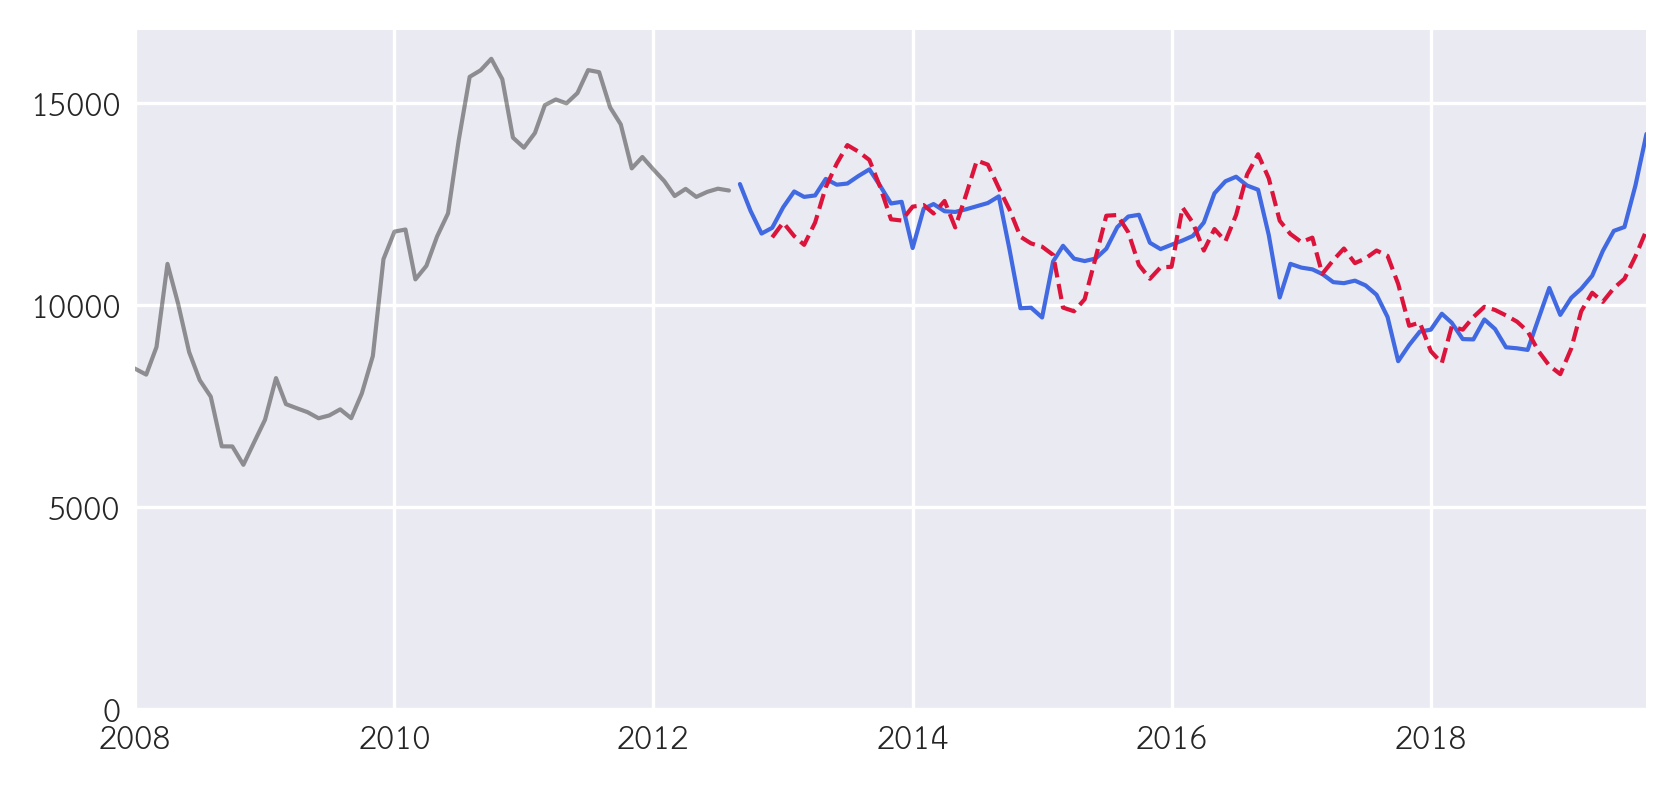

In [11]:
plot_fcast(glu, 'ets', step=4)